In [1]:
#Consumer evaluation of cars
#Determining best means of predicting if a car value is 'unacc', 'acc', 'good', 'vgood' based on:
#1)Cost to buy (very high, high, medium, low)
#2)Maintenance cost (very high, high, medium, low)
#3)Number of doors (2 doors, 4 doors, 5 or more doors)
#4)Amount of people space can accommodate (2 people, 4 people, more than 4 people)
#5)Storage space (small capacity, medium capacity, big capacity)
#6)Safety rating (low safety, medium safety, high safety)

import pandas as pd
import numpy as np
import sklearn
from IPython.display import display
from sklearn import model_selection
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [2]:
#Prepare dataframe and naming columns
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
data_col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'value']
dataset = pd.read_csv(data_url, names=data_col_names)
dataset = pd.DataFrame(dataset, index=range(1,len(dataset.index.values+1)), columns = data_col_names)
dataset.head()

,buying,maint,doors,persons,lug_boot,safety,value
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
5,vhigh,vhigh,2,2,med,high,unacc


In [3]:
#Clean string values with assigned values
#Convert categorical data (2 or 4 doors) into a numerical scale for comparison
dataset['value'].replace(['unacc', 'acc', 'good', 'vgood'], [1,2,3,4], inplace=True)
dataset['buying'].replace(['low','med','high','vhigh'], [1,2,3,4], inplace=True)
dataset['maint'].replace(['low', 'med', 'high', 'vhigh'], [1,2,3,4], inplace=True)
dataset['doors'].replace([2,4,'5more'], [1,2,3], inplace=True)
dataset['persons'].replace([2,4,'more'], [1,2,3], inplace=True)
dataset['lug_boot'].replace(['small','med','big'], [1,2,3], inplace=True)
dataset['safety'].replace(['low','med','high'], [1,2,3], inplace=True)

In [4]:
#Prepare X and Y data
dataset_split = dataset.values
X = dataset_split[:, 0:6].astype(int)
Y = dataset_split[:, 6].astype(int)
#Split 10% of data for testing
seed = 7
val_size = 0.1
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size = val_size, random_state = seed)

In [5]:
#Preparing model_selection by kfold cross validation analysis
models=[]
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', tree.DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
results_mean = []
results_std =[]
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits = 10, random_state = seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring = 'accuracy')
    results_mean.append(cv_results.mean())
    results_std.append(cv_results.std())
    names.append(name)
#Collect the results in descending order to determine accuracy of different models
cross_val_table = pd.DataFrame(np.column_stack([results_mean, results_std]),
                               index=names, columns = ('mean', 'standard deviation'))
cross_val_table = cross_val_table.sort_values(by='mean', ascending = False)
display(cross_val_table)

,mean,standard deviation
CART,0.967196,0.010517
SVM,0.961402,0.011845
KNN,0.930509,0.010668
LR,0.793424,0.018446
NB,0.707233,0.023604


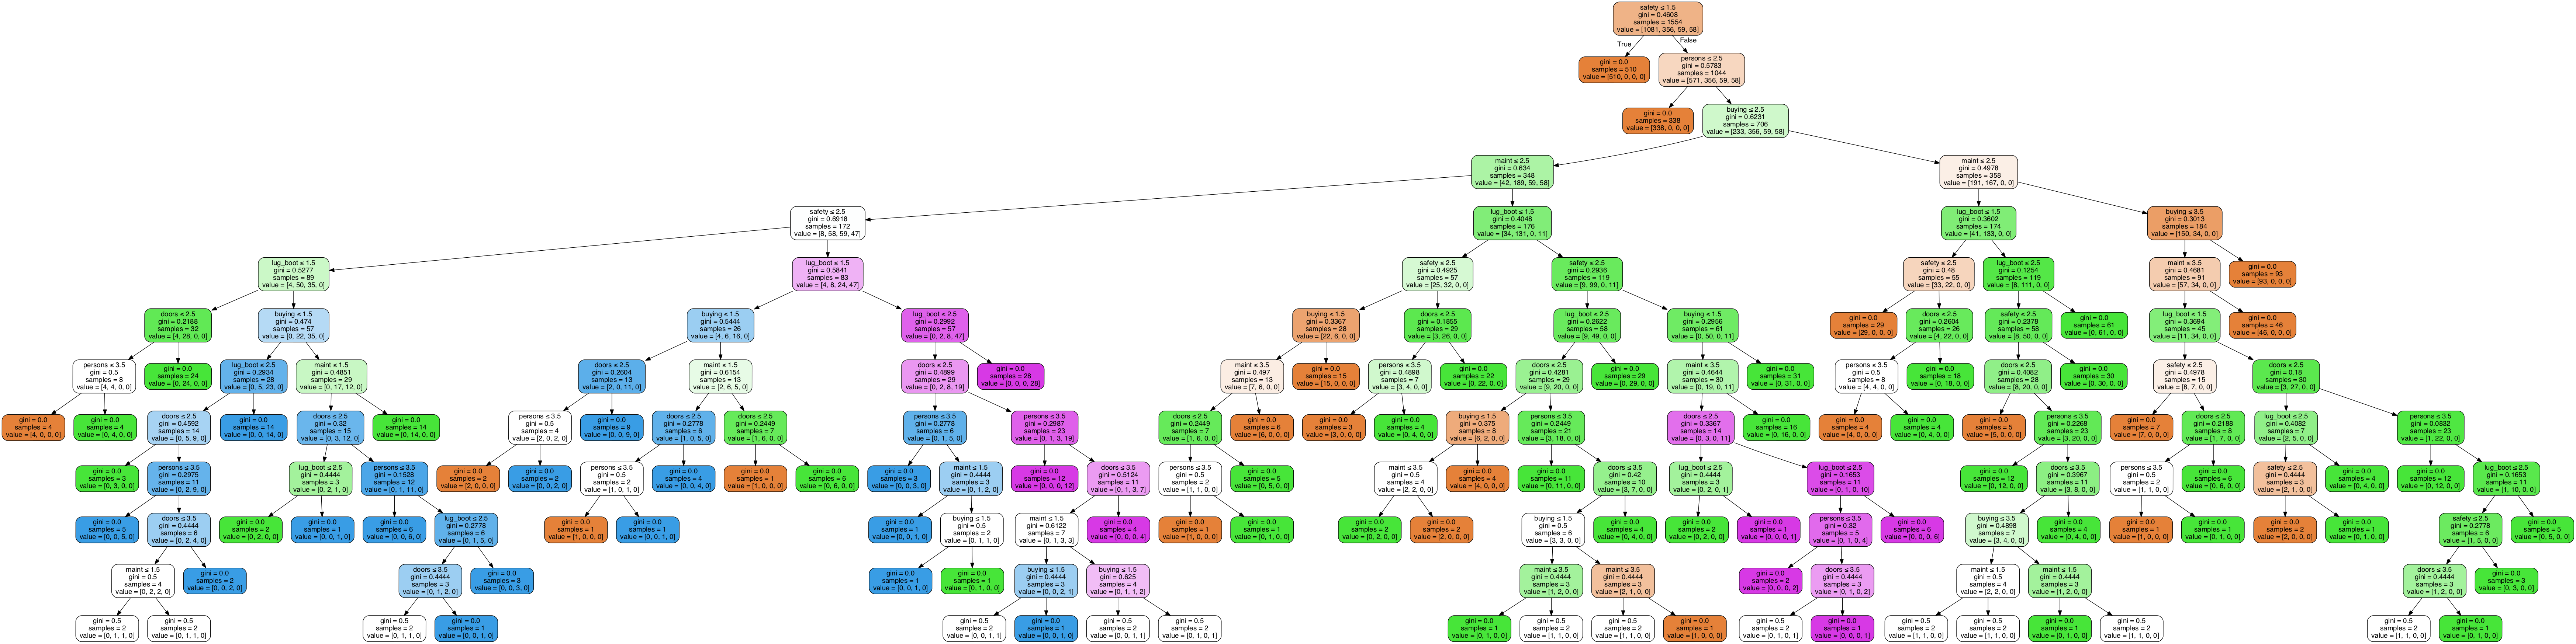

In [6]:
#Since the CART classifier resulted in the best accuracy, the data is modelled by decision trees
tree_clf = tree.DecisionTreeClassifier().fit(X_train, Y_train)
import pydotplus
from IPython.display import Image
tree_dot_data = tree.export_graphviz(tree_clf, out_file = None, feature_names = ['buying', 'maint', 'doors',
                                    'persons', 'lug_boot', 'safety'], class_names = Y.dtype.names, filled = True,
                                     rounded = True, special_characters = True)
tree_graph = pydotplus.graph_from_dot_data(tree_dot_data)
Image(tree_graph.create_png())

In [7]:
#Run a prediction on the X test data with the tree created
predicted_tree = tree_clf.predict(X_test)
#Determine the number of correct classifications and misclassifications
positives = 0
negatives = 0
for i in range(0,len(predicted_tree)):
    if predicted_tree[i] == Y_test[i]:
        positives+=1
    else:
        negatives+=1
#Determine the accuracy of the tree predictions
tree_accuracy = positives/(positives+negatives) * 100
#Print the accuracy to the 2nd decimal point
print ("The accuracy for this CART is {0:.2f}%.".format(tree_accuracy))
#Creating a table of all the incorrect predictions
wrong_index = []
wrong_predict = []
wrong_expect = []
for i in range (0, len(predicted_tree)):
    if predicted_tree[i] != Y_test[i]:
        wrong_index.append(i)
        wrong_predict.append(predicted_tree[i])
        wrong_expect.append(Y_test[i])
wrong_predictions = pd.DataFrame(np.column_stack([wrong_predict, wrong_expect]), index =
                                 wrong_index, columns = ('Predicted', 'Expected'))
#Display the number of misclassifications and show a table of where the misclassifications occured
print ("The number of incorrectly predicted tests are {}.".format(negatives))
print ()
print ("Displaying table of wrong predictions with index correlating to dataset index...")
display(wrong_predictions)

The accuracy for this CART is 97.11%.
The number of incorrectly predicted tests are 5.

Displaying table of wrong predictions with index correlating to dataset index...


,Predicted,Expected
19,1,2
68,3,4
97,2,1
128,1,2
146,3,2
